# Т.З.
1. По API забираем данные из Shoppilot https://help.aplaut.com/article/14680
и формируем файл по ТЗ

2.Файл, который выкладываете на сервер необходимо формировать в формате csv. Предпочтительно использовать 65001 (UTF-8). Необходимо, чтобы наименование файла содержило префикс Productrating.
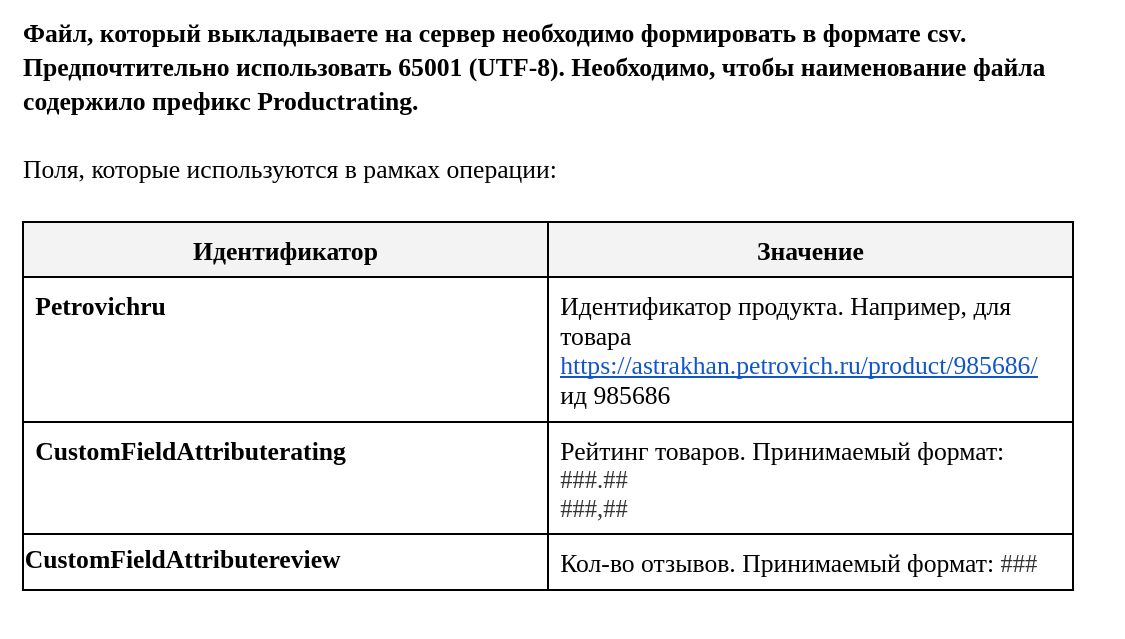

https://astrakhan.petrovich.ru/product/985686/

# НУЖНО УЗНАТЬ КОГДА РАБОТАЮТ СЕРВЕРА
С какого-то момента вечером и до 9 не работают, будет висеть статус waiting. Ночью не проверялось

In [7]:
import requests
import datetime
import csv
import pandas as pd
import time
from ftplib import FTP
import os

KEY_API = os.getenv("KEY_API")
HOSTNAME = os.getenv("HOSTNAME")
USERNAME = os.getenv("USERNAME")
PASSWORD = os.getenv("PASSWORD")


# Загрузка всех файлов папки, чтобы достать последний
ftp = FTP(HOSTNAME)
ftp.login(user=USERNAME, passwd=PASSWORD)
files = ftp.nlst('Processed')

ftp.quit()
# в какую дату была последняя загрузка
last_loaded = files[-1]
last_loaded = last_loaded.replace('Productrating_all_', '')
last_loaded = last_loaded.replace('.csv', '')
request_ids = []

# запрос на экспорт за период с даты последней загрузки (из названия последнего файла) до вчерашнего дня
def export_request(KEY_API, date):
  response = requests.post(url="https://api.aplaut.io/v4/export_tasks", headers= {'Authorization': f"Bearer {KEY_API}", 'Accept': 'application/vnd.api+json', 'Content-Type':'application/vnd.api+json'},
                        json = {
                            'data' : {
                              "type": "export_tasks",
                              "attributes":
                               {
                                  "records_type": "products", # тип записей - продукты
                                  "search_options": {
                                      "sort" : {
                                          "updated_at":"asc" # сортировка от меньшего id к большему
                                          },
                                      "filter": {
                                          "updated_at":{ # за какую дату от 00:00 до 23:59
                                              "gt": f"{last_loaded}T00:00:00",
                                              "lt": f"{date}T23:59:59"
                                              }
                                          }
                                                    },
                                  "format": "csv",
                                  "export_format": "[.updated_at?, .external_id?, .rating?, .published_group_reviews_count?]" # external_id - id продукта на сайте (есть в карточке)
                                }
                              }
                            }
                        )

  try:
    # проверка на отказ выгрузки
    if response.json()['data']['attributes']['refuse_reason']:
      refuse = {'server_refuse': response.json()['data']['attributes']['refuse_reason']}
      return refuse
    else: # если всё хорошо то возвращает Id
      id = {'id' : response.json()['data']['id']}
      print('Успешный запрос на экспорт')
      return id
  except: # сбор ошибок
    try:
      errors = {'server_error' : response.json()['errors']}
      return errors
    except Exception as e:
      return e

# запрос результата экспорта
def status_check(id, KEY_API):
  url = f"https://api.aplaut.io/v4/export_tasks/{id}"
  response = requests.get(url=url, headers= {'Authorization': f"Bearer {KEY_API}", 'Accept': 'application/vnd.api+json', 'Content-Type':'application/vnd.api+json'})

  status = response.json()['data']['attributes']['state']

  # проверка статуса экспорта
  try:
    if status == 'completed':
        data = pd.read_csv(response.json()['data']['attributes']['archive_url'], compression='gzip')
        print("Данные успешно загружены")
        return {'data': data}
    elif status == 'rejected':
        error = {"Export error": response.json()['data']['attributes']}
        return error
    else:
        print(status)
        time.sleep(30)
        return status_check(id, KEY_API)
  except Exception as e:
      return e

# загрузка отчёта
def report(KEY_API, date, last_id):

  try:
    export_id = export_request(KEY_API, date) # запрос на получение id экспорта

    start = time.time()

    try:
      request_ids.append(export_id['id'])

    except:
      request_ids.append(export_id)

    try: # если получен id экспорта - запрос на получение данных, если нет - отчёт об ошибках

      productrating_report = status_check(export_id['id'], KEY_API)

    except:
      return export_id, request_ids

    try: #если данные получены - извлечение датафрейма из словаря, если нет - отчёт об ошибках
      productrating_report_data = productrating_report['data']

    except:
      return productrating_report, request_ids

    if len(productrating_report_data) < 500000:    # проверка на лимит

      productrating_report_data = productrating_report_data.rename(columns={'EXTERNAL ID':'Petrovichru', 'RATING':'CustomFieldAttributerating',
                                                'PUBLISHED GROUP REVIEWS COUNT':'CustomFieldAttributereview'})

      productrating_report_data.drop_duplicates(inplace=True)

      return productrating_report_data, request_ids

    else: # если лимит достигнут, то повторяется запрос с фильтром дата > последней полученной и собирается в один фрейм

      update_date = datetime.datetime.strptime(productrating_report_data['UPDATED AT'].iloc[-1], '%Y-%m-%dT%H:%M:%S.%f%z').date()

      end = time.time()

      if (end - start) < 60:
        time.sleep(61 - (end - start))

      additional_report = report(KEY_API, update_date, request_ids)

      try:
        concantenated_report = pd.concat([productrating_report_data, additional_report])

        concantenated_report = concantenated_report.rename(columns={'EXTERNAL ID':'Petrovichru',    'RATING':'CustomFieldAttributerating',
                                                  'PUBLISHED GROUP REVIEWS COUNT':'CustomFieldAttributereview'})

        concantenated_report.drop_duplicates(inplace=True)

        return concantenated_report, request_ids

      except:
        print(f"Дозагрузка не удалась,  update_date = {update_date},  last_id = {last_id}")
        productrating_report_data.drop_duplicates(inplace=True)

        return productrating_report_data, request_ids

  except KeyboardInterrupt:
    try:
      return productrating_report_data, request_ids
    except:
      productrating_report_data = 'None'
      return productrating_report_data, request_ids

## Загрузка отчёта за вчерашний день
past_date = datetime.date.today() - datetime.timedelta(days=1) # ищем прошлую дату
productrating, request_id_list = report(KEY_API, past_date, request_ids)
productrating.drop(columns=['UPDATED AT'], inplace=True)
productrating = productrating.astype({"Petrovichru":'str',
                                      "CustomFieldAttributerating":'int8',
                                      "CustomFieldAttributereview":'int32'})

ftp = FTP(HOSTNAME)
ftp.login(user=USERNAME,passwd = PASSWORD)
file_path = f'/Processed/Productrating_all_{last_loaded}.csv'
with open('old_productrating_data.csv', 'wb') as file:
  ftp.retrbinary(f"RETR {file_path}", file.write)
ftp.quit()

new_rating = pd.read_csv("old_productrating_data.csv")
new_rating = new_rating.astype({"Petrovichru":'str', "CustomFieldAttributerating":'int8', "CustomFieldAttributereview":'int32'})

petr_ids = list(new_rating['Petrovichru'])
for index in list(productrating['Petrovichru']):
  if index not in petr_ids:
    new_rating = pd.concat([new_rating,productrating.iloc[list(productrating[productrating['Petrovichru']==index].index)]])

new_rating.reset_index(inplace=True, drop=True)
productrating = productrating.set_index('Petrovichru')
new_rating = new_rating.set_index('Petrovichru')
new_rating.update(productrating)

filename = f"Productrating_all_{past_date}.csv"
new_rating.to_csv(filename)

# загрузка файла на сервер
ftp = FTP(HOSTNAME)
ftp.login(user=USERNAME,passwd = PASSWORD)
ftp.encoding = "utf-8"
with open(filename, "rb") as file:
    ftp.storbinary(f"STOR /Processed/{filename}", file)
ftp.quit()

# Чтобы проверить наличие файла в папке ⬇
# ftp = FTP(HOSTNAME)
# ftp.login(user=USERNAME, passwd=PASSWORD)
# files = ftp.nlst('Processed')
# print(files[-1])
# ftp.quit()

Успешный запрос на экспорт
processing
Данные успешно загружены


<ipython-input-7-276db7859de7>:178: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  new_rating = pd.read_csv("old_productrating_data.csv")


Productrating_all_2024-05-23.csv


'221 Goodbye.'